# Анализ юнит-экономики приложения Procrastinate Pro+

## Бизнес-задача

Вы — маркетинговый аналитик развлекательного приложения Procrastinate Pro+. Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. Ваша задача — разобраться в причинах и помочь компании выйти в плюс. 

В бизнес-модели компании заложено, что пользователь должен окупиться за 14 дней после привлечения. Текущая дата: 1 ноября 2019 года.

## Ключевые выводы и рекомендации

Основной поток маркетинговых расходов (82.7%) приходится на каналы TipTop и FaceBoom. Несмотря на относительно высокие показатели конверсии для данных каналов, юниты, привлеченные через них, не окупаются. Масштабирование проекта за счет данных каналов будет вести к дальнейшему масштабированию убытков. Среди каналов, задействованных в Европе, убыточным оказался маркетинговый канал AdNonSense.

Рекомендуется перераспределить маркетинговый бюджет на другие каналы привлечения пользователей: в Европе следует сделать выбора в пользу lambdaMediaAds (ROI = 1.348) и LeapBob (ROI = 1.122), а в США - MediaTornado (ROI = 1.003) и YRabbit (ROI = 0.943). Для этих каналов характерна наибольшая окупаемость затрат на маркетинг к 14 дню после привлечения. 

Также следует уделить внимание развитию лояльности клиентов - сейчас наблюдается низкий уровень перехода из платного трафика в органический, пользователи редко возвращаются на сайт без повторного маркетингового воздействия. Развитие лояльности позволит снизить затраты, которые сейчас уходят на удержание внимания пользователей.

## Описание данных

visits:
- User Id — уникальный идентификатор пользователя
- Device — категория устройства пользователя
- Session Start — дата и время начала сессии
- Session End — дата и время окончания сессии
- Channel — идентификатор маркетингового канала
- Region — регион пользователя

orders:
- User Id — уникальный идентификатор пользователя
- Event Dt — дата и время покупки
- Revenue — стоимость заказа

costs:
- Channel — идентификатор маркетингового канала
- Dt — дата коммуникации
- Costs — затраты на маркетинговый канал

## Анализ данных

### Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportion_confint
from datetime import date, timedelta, datetime

### Настройка отображения чисел

In [2]:
pd.options.display.float_format = '{:.3f}'.format

### Загрузка данных

In [3]:
# данные о расходах на рекламу
costs = pd.read_csv(r'C:\Users\Вадим\my_projects\unit_economy\dataset\costs_info_short.csv',
                    parse_dates = ['dt'])

# данные о заказах
orders = pd.read_csv(r'C:\Users\Вадим\my_projects\unit_economy\dataset\orders_info_short.csv', 
                     dtype = {'User Id': 'object'},
                     parse_dates = ['Event Dt'])

# данные о посещениях сайта
visits = pd.read_csv(r'C:\Users\Вадим\my_projects\unit_economy\dataset\visits_info_short.csv', 
                     dtype = {'User Id': 'object'},
                     parse_dates = ['Session Start', 'Session End'])

### EDA

#### Расходы на рекламу

##### Summary

Продвижение приложения происходит через 10 каналов: FaceBoom, MediaTornado, RocketSuperAds, TipTop, YRabbit, AdNonSense, LeapBob, OppleCreativeMedia, WahooNetBanner, lambdaMediaAds. К каждому из каналов в рамках рассматриваемого периода компания прибегла 180 раз.

75% маркетинговых кампаний обходятся компании в 33.6 долларов и ниже, однако есть "длинный хвост" из более дорогостоящих маркетинговых кампаний. Максимальное значение расходов на рекламу достигает 630 долларов.

В датасете представлены данные о маркетинговых кампаниях с 1 мая 2019 по 27 октября 2019 года. Суммарные маркетинговые затраты в этот период составили 105 497 долларов. При этом 82.7% бюджета ушло на продвижение всего в двух каналах: TipTop (51.9%) и FaceBoom (30.8%). Расходы на маркетинг росли на протяжении всего исследуемого периода, причем за этот рост, в первую очередь, отвечают растущие расходы на канал TipTop.

Пропуски и дубликаты в данных отсутствуют.

##### Code

In [4]:
costs.head()

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.300
1,2019-05-02,FaceBoom,78.100
2,2019-05-03,FaceBoom,85.800
3,2019-05-04,FaceBoom,136.400
4,2019-05-05,FaceBoom,122.100


In [5]:
# пропуски в данных
print('Пропуски:')
print(costs.isna().sum())
print('---')
print('Дубликаты:')
# дубликаты
print(costs.duplicated().sum())

Пропуски:
dt         0
Channel    0
costs      0
dtype: int64
---
Дубликаты:
0


In [6]:
# каналы продвижения
print('Количество каналов продвижения: ', costs['Channel'].nunique())
print('Каналы продвижения:', ', '.join(costs['Channel'].unique()))

Количество каналов продвижения:  10
Каналы продвижения: FaceBoom, MediaTornado, RocketSuperAds, TipTop, YRabbit, AdNonSense, LeapBob, OppleCreativeMedia, WahooNetBanner, lambdaMediaAds


In [7]:
# распределение кампаний по каналам продвижения
costs['Channel'].value_counts()

Channel
FaceBoom              180
MediaTornado          180
RocketSuperAds        180
TipTop                180
YRabbit               180
AdNonSense            180
LeapBob               180
OppleCreativeMedia    180
WahooNetBanner        180
lambdaMediaAds        180
Name: count, dtype: int64

In [8]:
# описательные статистики
costs.describe()

,dt,costs
count,1800,1800.000
mean,2019-07-29 12:00:00.000000256,58.610
min,2019-05-01 00:00:00,0.800
25%,2019-06-14 18:00:00,6.495
50%,2019-07-29 12:00:00,12.285
75%,2019-09-12 06:00:00,33.600
max,2019-10-27 00:00:00,630.000
std,NaN,107.740


In [9]:
# общие расходы на рекламу
float(costs['costs'].sum())

105497.30000000002

In [10]:
marketing_cost = costs.groupby('Channel').agg(
    {'costs': 'sum'}
).reset_index().rename(columns = {'costs': 'Sum_Cost'}).sort_values('Sum_Cost', ascending = False)

marketing_cost['Percent_Cost'] = marketing_cost['Sum_Cost'] / float(costs['costs'].sum()) * 100

marketing_cost.style.format({'Sum_Cost': '{:.0f}$', 'Percent_Cost': '{:.2f}%'})

,Channel,Sum_Cost,Percent_Cost
6,TipTop,54751$,51.90%
1,FaceBoom,32446$,30.75%
7,WahooNetBanner,5151$,4.88%
0,AdNonSense,3911$,3.71%
4,OppleCreativeMedia,2151$,2.04%
5,RocketSuperAds,1833$,1.74%
2,LeapBob,1798$,1.70%
9,lambdaMediaAds,1558$,1.48%
3,MediaTornado,954$,0.90%
8,YRabbit,944$,0.90%


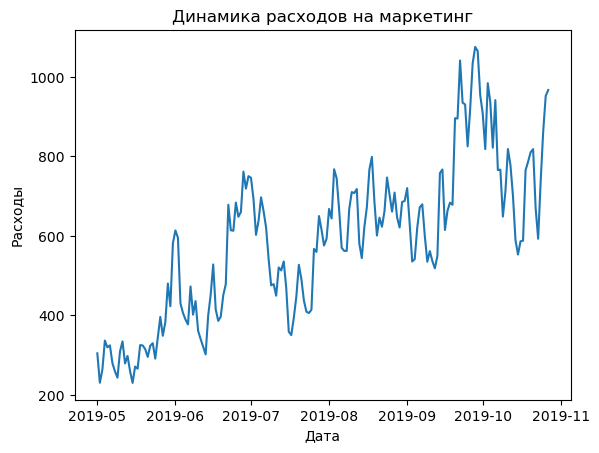

In [11]:
# динамика маркетинговых расходов

sns.lineplot(
    data = costs.groupby('dt').agg({'costs': 'sum'}).reset_index(),
    x = 'dt',
    y = 'costs'
)

plt.title('Динамика расходов на маркетинг')
plt.xlabel('Дата')
plt.ylabel('Расходы')

plt.show()

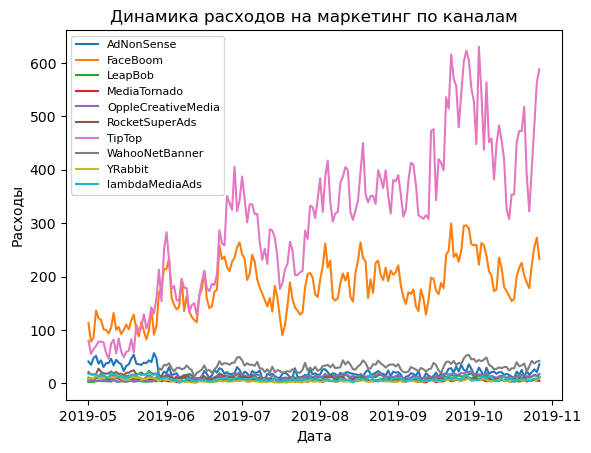

In [12]:
# динамика маркетинговых расходов по каналам
sns.lineplot(
    data = costs.groupby(['Channel', 'dt']).agg({'costs': 'sum'}).reset_index(),
    x = 'dt',
    y = 'costs',
    hue = 'Channel'
)

plt.legend(prop={'size': 8})

plt.title('Динамика расходов на маркетинг по каналам')
plt.xlabel('Дата')
plt.ylabel('Расходы')

plt.show()

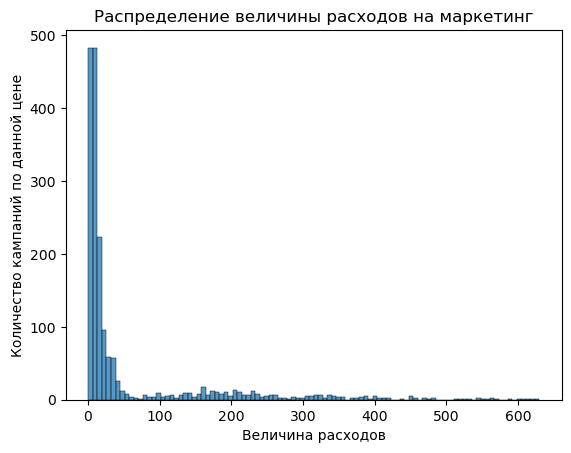

In [13]:
# распределение расходов на рекламу
sns.histplot(data = costs['costs'], bins = 100)

plt.title('Распределение величины расходов на маркетинг')
plt.xlabel('Величина расходов')
plt.ylabel('Количество кампаний по данной цене')

plt.show()

#### Заказы

##### Summary

В датасете представлены данные о 8 881 клиентах, совершивших 40 212 транзакций в период с 1 мая 2019 по 31 октября 2019 года.

96% транзакций приходятся на покупки по минимальной цене в 4.99 доллара. Остальные 4% транзакций приходятся на заказы от 5.99 до 19.99 доллара.

Пропуски и дубликаты в данных отсутствуют.

##### Code

In [14]:
orders.head()

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.990
1,174361394180,2019-05-01 12:24:04,4.990
2,529610067795,2019-05-01 11:34:04,4.990
3,319939546352,2019-05-01 15:34:40,4.990
4,366000285810,2019-05-01 13:59:51,4.990


In [15]:
# пропуски в данных
print('Пропуски:')
print(orders.isna().sum())
print('---')
print('Дубликаты:')
# дубликаты
print(orders.duplicated().sum())

Пропуски:
User Id     0
Event Dt    0
Revenue     0
dtype: int64
---
Дубликаты:
0


In [16]:
# количество уникальных клиентов
print('Количество уникальных клиентов: ', orders['User Id'].nunique())

Количество уникальных клиентов:  8881


In [17]:
# описательные статистики
orders.describe()

,Event Dt,Revenue
count,40212,40212.000
mean,2019-08-18 21:31:11.158037504,5.371
min,2019-05-01 00:28:11,4.990
25%,2019-07-10 20:15:34.249999872,4.990
50%,2019-08-24 15:15:30,4.990
75%,2019-09-30 05:24:46.500000,4.990
max,2019-10-31 23:56:56,49.990
std,NaN,3.454


In [18]:
# процентное распределение выручки с транзакции
orders['Revenue'].value_counts(normalize = True) * 100

Revenue
4.990    96.068
5.990     1.940
9.990     0.957
49.990    0.527
19.990    0.507
Name: proportion, dtype: float64

#### Посещения сайта

##### Summary

В датасете представлены данные о 309 901 посещении сайта, совершенными 150 008 пользователями в период с 1 мая 2019 по 31 октября 2019 года.

Пользователи посещают сайт с iPhone, Mac, Android и PC. На мобильные устройства приходится 60% посещений - чаще всего визиты происходят с iPhone.

Охвачены регионы: США, Великобритания, Франция и Германия. Чаще всего сайт посещают из США, реже всего - из Германии. В Европе задействованы каналы продвижения: AdNonSense, LeapBob, OppleCreativeMedia, WahooNetBanner, lambdaMediaAds, а в США: FaceBoom, MediaTornado, RocketSuperAds, TipTop, YRabbit.

Не более 5% транзакций пользователей конвертируются в "органические" после привлечения через платные каналы. Последующие визиты также происходят через платные каналы, следовательно, требуют расходов со стороны компании.

Пропуски и дубликаты в данных отсутствуют.

##### Code

In [19]:
visits.head()

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


In [20]:
# пропуски в данных
print('Пропуски:')
print(visits.isna().sum())
print('---')
print('Дубликаты:')
# дубликаты
print(visits.duplicated().sum())

Пропуски:
User Id          0
Region           0
Device           0
Channel          0
Session Start    0
Session End      0
dtype: int64
---
Дубликаты:
0


In [21]:
# количество уникальных пользователей
print('Количество уникальных пользователей: ', visits['User Id'].nunique())

# устройства входа
print('Устройства входа:', ', '.join(visits['Device'].unique()))

# охватываемые регионы
print('Охватываемые регионы:', ', '.join(visits['Region'].unique()))

# каналы
print('Каналы:', ', '.join(visits['Channel'].unique()))

Количество уникальных пользователей:  150008
Устройства входа: iPhone, Mac, Android, PC
Охватываемые регионы: United States, UK, France, Germany
Каналы: organic, TipTop, RocketSuperAds, YRabbit, FaceBoom, MediaTornado, AdNonSense, LeapBob, WahooNetBanner, OppleCreativeMedia, lambdaMediaAds


In [22]:
# описательные статистики
visits.describe()

,Session Start,Session End
count,309901,309901
mean,2019-08-06 13:29:38.176540416,2019-08-06 13:59:38.267408384
min,2019-05-01 00:00:41,2019-05-01 00:07:06
25%,2019-06-23 22:17:33,2019-06-23 22:52:40
50%,2019-08-10 10:56:43,2019-08-10 11:19:41
75%,2019-09-23 00:23:42,2019-09-23 00:54:41
max,2019-10-31 23:59:23,2019-11-01 01:38:46


In [23]:
# процентное распределение посещений по регионам
visits['Region'].value_counts(normalize = True) * 100

Region
United States   66.901
UK              11.752
France          11.422
Germany          9.925
Name: proportion, dtype: float64

In [24]:
# процентное распределение посещений по устройствам
visits['Device'].value_counts(normalize = True) * 100

Device
iPhone    36.335
Android   23.424
PC        20.228
Mac       20.013
Name: proportion, dtype: float64

In [25]:
# процентное распределение посещений по каналам
visits['Channel'].value_counts(normalize = True) * 100

Channel
organic              34.772
TipTop               17.681
FaceBoom             15.819
WahooNetBanner        6.604
LeapBob               5.490
OppleCreativeMedia    5.419
RocketSuperAds        4.106
YRabbit               2.921
MediaTornado          2.865
AdNonSense            2.224
lambdaMediaAds        2.100
Name: proportion, dtype: float64

In [26]:
# конвертируются ли пользователи в "органических" после взаимодействия с платным каналом?

# достаем информацию о первых визитах по каждому пользователю
first_visit = visits.sort_values(by = ['User Id', 'Session Start']).groupby(by = 'User Id').nth(0)

# join всех визитов и канала, через который пользователь был привлечен
all_visits = visits.merge(first_visit, how = 'left', on = 'User Id', suffixes = (None, '_first'))

# crosstab канал первого визита пользователя X каналы последующих визитов
pd.crosstab(all_visits[all_visits['Session Start'] != all_visits['Session Start_first']]['Channel'], all_visits[all_visits['Session Start'] != all_visits['Session Start_first']]['Channel_first'], normalize='columns')

Channel_first,AdNonSense,FaceBoom,LeapBob,MediaTornado,OppleCreativeMedia,RocketSuperAds,TipTop,WahooNetBanner,YRabbit,lambdaMediaAds,organic
Channel,,,,,,,,,,,
AdNonSense,0.915,0.000,0.006,0.000,0.006,0.000,0.000,0.007,0.000,0.009,0.002
FaceBoom,0.000,0.954,0.000,0.027,0.000,0.013,0.008,0.000,0.023,0.000,0.005
LeapBob,0.019,0.000,0.949,0.000,0.012,0.000,0.000,0.007,0.000,0.012,0.003
MediaTornado,0.000,0.006,0.000,0.871,0.000,0.010,0.005,0.000,0.009,0.000,0.004
OppleCreativeMedia,0.016,0.000,0.011,0.000,0.952,0.000,0.000,0.011,0.000,0.010,0.002
RocketSuperAds,0.000,0.007,0.000,0.011,0.000,0.922,0.006,0.000,0.014,0.000,0.004
TipTop,0.000,0.015,0.000,0.036,0.000,0.026,0.965,0.000,0.047,0.000,0.007
WahooNetBanner,0.012,0.000,0.014,0.000,0.011,0.000,0.000,0.948,0.000,0.015,0.003
YRabbit,0.000,0.005,0.000,0.008,0.000,0.008,0.006,0.000,0.866,0.000,0.004


In [27]:
# в каких регионах задействованы каналы?
pd.crosstab(visits['Region'], visits['Channel'])

Channel,AdNonSense,FaceBoom,LeapBob,MediaTornado,OppleCreativeMedia,RocketSuperAds,TipTop,WahooNetBanner,YRabbit,lambdaMediaAds,organic
Region,,,,,,,,,,,
France,2381,0,5869,0,5808,0,0,7033,0,2241,12064
Germany,2183,0,4892,0,4865,0,0,6324,0,1976,10519
UK,2327,0,6252,0,6121,0,0,7108,0,2290,12321
United States,0,49022,0,8878,0,12724,54794,0,9053,0,72856


### Конверсия

#### Summary

Наиболее высокую конверсию из пользователя в клиента обеспечивают каналы FaceBoom и TipTop в США, а в Европе - AdNonSense и lambdaMediaAds (от 9.6% до 12.2%). Наименее эффективны с точки зрения конверсии каналы YRabbit и MediaTornado в США, а в Европе - LeapBob, OppleCreativeMedia (конверсия менее 5%). Органические пользователи конвертируются в клиентов слабо - 2.1%. Клиенты, пришедшие из каналов FaceBoom и TipTop, составляют 61.2% от всех покупателей в рассматриваемый период.

Среди регионов присутствия приложения по конверсии выделяется США - 6.9%. В Европе ситуация несколько хуже - конверсия варьируется от 3.8 до 4.1%. 

Лучше всего в клиентов конвертируются владельцы Mac - 7.5%, а хуже всего - пользователи PC - 6.2%. Владельцы Android и IPhone по конверсии статистически значимо не отличаются друг от друга.

#### Code

In [28]:
# профиль пользователя

# добавляем к посещениям флаг даты кампании, с которой они пришли
all_visits['Channel_Dt_Flag'] = all_visits['Session Start'].dt.date

# для тех, кто пришел после 27 октября, считаем датой кампании 27 октября
all_visits.loc[all_visits['Session Start'] > '2019-10-28', 'Channel_Dt_Flag'] = '2019-10-27'
all_visits['Channel_Dt_Flag'] = pd.to_datetime(all_visits['Channel_Dt_Flag'])

# подтягиваем стоимости маркетинговых кампаний
visits_costs = all_visits.merge(costs, how = 'left', left_on = ['Channel', 'Channel_Dt_Flag'], right_on = ['Channel', 'dt'])

# сколько переходов пришло в конкретную дату с канала
click_acquisition = visits_costs.groupby(['Channel_Dt_Flag', 'Channel']).size().reset_index()
click_acquisition = click_acquisition.rename(columns = {0: 'click_count'})
visits_costs = visits_costs.merge(click_acquisition, how = 'left', on = ['Channel', 'Channel_Dt_Flag']) 

# стоимость органического трафика == 0
visits_costs['costs'] = visits_costs['costs'].fillna(0)

# рассчитываем стоимость кликов
visits_costs['cpc'] = visits_costs['costs'] / visits_costs['click_count']

# формируем датасет с профилем пользователя
profile = visits_costs[visits_costs['Session Start'] == visits_costs['Session Start_first']][['User Id', 'Region', 'Device_first', 'Channel_first',
                                                                                             'Session Start_first', 'Channel_Dt_Flag', 'cpc']]
# фиксируем дату первого посещения
profile['Session Start_month'] = profile['Session Start_first'].dt.month
profile['Session Start_first'] = profile['Session Start_first'].dt.date

# в качестве стоимости привлечения пользователя считаем стоимость его первого перехода на сайт
profile = profile.rename(columns = {'cpc': 'CPA'})

# суммарную стоимость остальных кликов пользователя считаем стоимостью удержания
retention_cost = visits_costs[visits_costs['Session Start'] != visits_costs['Session Start_first']].groupby('User Id').agg({'cpc': 'sum'})
profile = profile.merge(retention_cost, how = 'left', on = 'User Id')
profile = profile.rename(columns = {'cpc': 'RCPU'})
profile['RCPU'] = profile['RCPU'].fillna(0)

# суммарные маркетинговые затраты на пользователя
profile['MCPU'] = profile['CPA'] + profile['RCPU']

# является ли юнит клиентом?
profile['Customer'] = profile['User Id'].isin(orders['User Id'].unique()).astype(int)

# итоговый датасет
profile.head()

,User Id,Region,Device_first,Channel_first,Session Start_first,Channel_Dt_Flag,CPA,Session Start_month,RCPU,MCPU,Customer
0,981449118918,United States,iPhone,organic,2019-05-01,2019-05-01,0.000,5,0.157,0.157,0
1,278965908054,United States,iPhone,organic,2019-05-01,2019-05-01,0.000,5,0.000,0.000,0
2,590706206550,United States,Mac,organic,2019-05-01,2019-05-01,0.000,5,0.000,0.000,0
3,326433527971,United States,Android,TipTop,2019-05-01,2019-05-01,0.976,5,0.645,1.620,0
4,349773784594,United States,Mac,organic,2019-05-01,2019-05-01,0.000,5,0.000,0.000,0


In [29]:
# функция для расчета доверительного интервала для доли
def ci(data, confidence_level = 0.95):
    n_success = data.sum()
    n_total = data.count()
    lower_bound, upper_bound = proportion_confint(n_success, n_total, alpha = 1 - confidence_level)
    return lower_bound * 100, upper_bound * 100

In [30]:
# величина конверсии по регионам

reg_conversion = profile.groupby('Region').agg(
    {'User Id': 'count', 'Customer': 'mean'}
).reset_index().rename(columns = {'User Id': 'Unit', 'Customer': 'Conversion'}).sort_values('Conversion', ascending = False)

reg_conversion['Conversion'] = reg_conversion['Conversion'] * 100

# определение доверительного интервала для конверсии
lower_bound = []
upper_bound = []
for i in reg_conversion['Region'].unique():
    data = profile[profile['Region'] == i]['Customer']
    lower, upper = ci(data)
    lower_bound.append(lower)
    upper_bound.append(upper)

reg_conversion['Conversion_95_lower'] = lower_bound
reg_conversion['Conversion_95_upper'] = upper_bound

reg_conversion.style.format({'Conversion': '{:.2f}%', 'Conversion_95_lower': '{:.2f}%', 'Conversion_95_upper': '{:.2f}%'})

,Region,Unit,Conversion,Conversion_95_lower,Conversion_95_upper
3,United States,100002,6.90%,6.74%,7.06%
1,Germany,14981,4.11%,3.79%,4.43%
2,UK,17575,3.98%,3.69%,4.27%
0,France,17450,3.80%,3.52%,4.08%


In [31]:
# величина конверсии по каналам привлечения 

channel_conversion = profile.groupby('Channel_first').agg(
    {'User Id': 'count', 'Customer': 'mean'}
).reset_index().rename(columns = {'User Id': 'Unit', 'Customer': 'Conversion'}).sort_values('Conversion', ascending = False)

channel_conversion['Conversion'] = channel_conversion['Conversion'] * 100

# определение доверительного интервала для конверсии
lower_bound = []
upper_bound = []
for i in channel_conversion['Channel_first'].unique():
    data = profile[profile['Channel_first'] == i]['Customer']
    lower, upper = ci(data)
    lower_bound.append(lower)
    upper_bound.append(upper)

channel_conversion['Conversion_95_lower'] = lower_bound
channel_conversion['Conversion_95_upper'] = upper_bound

channel_conversion.style.format({'Conversion': '{:.2f}%', 'Conversion_95_lower': '{:.2f}%', 'Conversion_95_upper': '{:.2f}%'})

,Channel_first,Unit,Conversion,Conversion_95_lower,Conversion_95_upper
1,FaceBoom,29144,12.20%,11.83%,12.58%
0,AdNonSense,3880,11.34%,10.34%,12.34%
9,lambdaMediaAds,2149,10.47%,9.18%,11.76%
6,TipTop,19561,9.60%,9.19%,10.01%
5,RocketSuperAds,4448,7.91%,7.12%,8.71%
7,WahooNetBanner,8553,5.30%,4.82%,5.77%
8,YRabbit,4312,3.83%,3.25%,4.40%
3,MediaTornado,4364,3.57%,3.02%,4.13%
2,LeapBob,8553,3.06%,2.70%,3.43%
4,OppleCreativeMedia,8605,2.71%,2.36%,3.05%


In [32]:
device = visits[['User Id', 'Device']].drop_duplicates()
device['Customer'] = device['User Id'].isin(orders['User Id'].unique()).astype(int)

device_conversion = device.groupby('Device').agg(
    {'User Id': 'count', 'Customer': 'mean'}
).reset_index().rename(columns = {'User Id': 'Unit', 'Customer': 'Conversion'}).sort_values('Conversion', ascending = False)


device_conversion['Conversion'] = device_conversion['Conversion'] * 100

# определение доверительного интервала для конверсии
lower_bound = []
upper_bound = []
for i in device_conversion['Device'].unique():
    data = device[device['Device'] == i]['Customer']
    lower, upper = ci(data)
    lower_bound.append(lower)
    upper_bound.append(upper)

device_conversion['Conversion_95_lower'] = lower_bound
device_conversion['Conversion_95_upper'] = upper_bound

device_conversion.style.format({'Conversion': '{:.2f}%', 'Conversion_95_lower': '{:.2f}%', 'Conversion_95_upper': '{:.2f}%'})

,Device,Unit,Conversion,Conversion_95_lower,Conversion_95_upper
1,Mac,31335,7.49%,7.20%,7.78%
0,Android,36377,6.76%,6.50%,7.01%
3,iPhone,55798,6.75%,6.54%,6.96%
2,PC,31681,6.15%,5.88%,6.41%


In [33]:
profile.groupby('Channel_first').agg({'Customer': 'sum'}).sort_values('Customer', ascending = False) / profile['Customer'].sum() * 100

,Customer
Channel_first,
FaceBoom,40.052
TipTop,21.146
organic,13.062
WahooNetBanner,5.101
AdNonSense,4.954
RocketSuperAds,3.964
LeapBob,2.950
OppleCreativeMedia,2.624
lambdaMediaAds,2.533


### Маркетинговые затраты на юнит масштабирования

#### Summary

Поскольку клиенты приложения Procrastinate Pro+ не переходят в органический трафик после привлечения, более точные результаты мы получим, рассматривая не стоимость привлечения по каналам (CAC), а все маркетинговые затраты на юнита, привлеченного через конкретный канал.

Наиболее высокие маркетинговые затраты на юнит масштабирования приходятся на каналы TipTop (2.75 доллара) и FaceBoom (1.10 доллара). Следом идут европейские каналы привлечения AdNonSense (0.97 доллара) и lambdaMediaAds (0.71 доллара).



#### Code

In [34]:
# marketing cost per unit по каналам привлечения
profile.groupby('Channel_first').agg({'MCPU': 'mean'}).reset_index().sort_values('MCPU', ascending = False).style.format({'MCPU': '{:.2f}$'})

,Channel_first,MCPU
6,TipTop,2.75$
1,FaceBoom,1.10$
0,AdNonSense,0.97$
9,lambdaMediaAds,0.71$
7,WahooNetBanner,0.60$
5,RocketSuperAds,0.46$
8,YRabbit,0.28$
3,MediaTornado,0.26$
4,OppleCreativeMedia,0.25$
2,LeapBob,0.21$


### Окупаемость юнита

#### Summary

К 14 дню не окупаются пользователи, привлеченные через каналы TipTop, FaceBoom и AdNonSense. Наибольший ROI (> 1) среди платных каналов характерен для lambdaMediaAds, LeapBob и MediaTornado.

Убыточна маркетинговая кампания в США, где основной поток юнитов приходится на каналы TipTop и FaceBoom. Лучше всего ситуация с окупаемостью в Великобритании (ROI = 0.965).

#### Code

In [35]:
profile['Session Start_first'] = pd.to_datetime(profile['Session Start_first'])

# определяем, к какому дню должен окупиться пользователь
profile['ROI_horizon'] = profile['Session Start_first'] + pd.Timedelta(days=14)

# исключаем пользователей, которые не дожили до горизонта анализа
horizon_date = date(2019, 11, 1) - timedelta(days = 13)
profile_analysis = profile[profile['Session Start_first'].dt.date < horizon_date]

# добавляем в датасет с заказами ROI_horizon
orders = orders.merge(profile_analysis, how = 'left', on = 'User Id')

# фильтруем заказы, которые наступили после даты окупаемости, заложенной в бизнес-модели
orders_analysis = orders[orders['Event Dt'] < orders['ROI_horizon']].groupby('User Id').agg({'Revenue': 'sum'})

# добавляем выручку к 14 дню к профилю пользователя
profile_analysis = profile_analysis.merge(orders_analysis, how = 'left', on = 'User Id')

# если значение не нашлось, то выручка к 14 дню == 0
profile_analysis['Revenue'] = profile_analysis['Revenue'].fillna(0)

# сколько мы в среднем тратим на юнит и получаем с него выручки
def get_roi_cm(profile_analysis, group):
    unit_return = profile_analysis.groupby(group).agg({'Revenue': 'mean', 'MCPU': 'mean'}).reset_index()
    unit_return['ROI'] = (unit_return['Revenue'] - unit_return['MCPU']) / unit_return['MCPU']
    unit_return['CM'] = (unit_return['Revenue'] - unit_return['MCPU'])

    return unit_return

In [39]:
# ROI и CM по каналам
unit_return = get_roi_cm(profile_analysis, 'Channel_first')
unit_return.sort_values('ROI', ascending = False)

,Channel_first,Revenue,MCPU,ROI,CM
10,organic,0.311,0.014,21.942,0.298
9,lambdaMediaAds,1.733,0.738,1.348,0.995
2,LeapBob,0.464,0.219,1.122,0.245
3,MediaTornado,0.533,0.266,1.003,0.267
8,YRabbit,0.550,0.283,0.943,0.267
5,RocketSuperAds,0.914,0.473,0.930,0.440
4,OppleCreativeMedia,0.407,0.257,0.586,0.150
7,WahooNetBanner,0.902,0.619,0.457,0.283
0,AdNonSense,0.837,0.976,-0.142,-0.139
1,FaceBoom,0.820,1.117,-0.266,-0.297


In [38]:
# ROI и CM по регионам
unit_return = get_roi_cm(profile_analysis, 'Region')
unit_return.sort_values('ROI', ascending = False)

,Region,Revenue,MCPU,ROI,CM
2,UK,0.583,0.296,0.965,0.286
1,Germany,0.571,0.302,0.890,0.269
0,France,0.515,0.294,0.751,0.221
3,United States,0.729,0.924,-0.210,-0.194
